# Tutorial: Oxygen Electro-Reduction Reaction

## Introduction

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from melektrodica import *
directory = os.path.join("examples","Moore2013Oxygen")
writer = Writer(log_file="Wang2007Hydrogen.log", log_directory=directory)
data = Collector(directory)
Kpy = Kpynetic(data)
melek = Calculator(Kpy)

# Retrieving data from Moore et al. [1]
theta_o = pd.read_csv(directory + "/MooreData/coverages_o.csv", comment='#').values
theta_oh = pd.read_csv(directory + "/MooreData/coverages_oh.csv", comment='#').values

coverages = {"OH": ("s", "-", theta_oh, 1), "O": ("o", "--", theta_o, 0)}
colors = ["#ffd9bf", "#ffb380", "#ff8c40", "#ff7f0e", "#ff6610"]

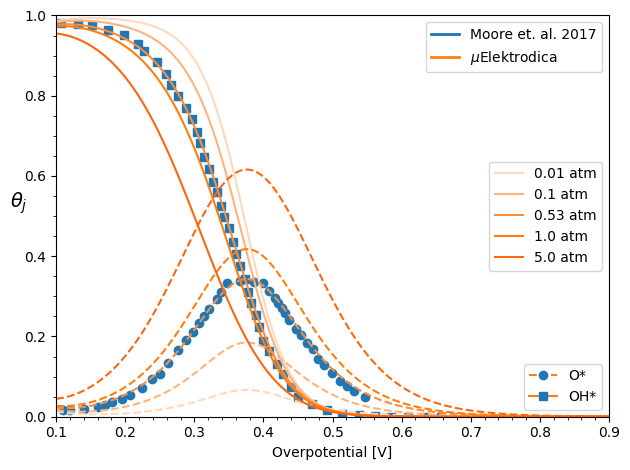

In [2]:
fname = os.path.join(directory, "MooreOxygen_theta.png")
c0_oxygen = np.array([0.01, 0.1, 0.53, 1, 5])
pressure_legend = []
for label, (mark, linest, _data, idx) in coverages.items():
    plt.plot(_data[:, 0], _data[:, 1], marker=mark, linestyle="", color="tab:blue")
for i, c0 in enumerate(c0_oxygen):
    melek.data.species.c0_reactants = np.array([c0, 1])
    results=melek.strategy.solver()
    plt.plot(melek.potential, results.theta[:, 0], linestyle="--",color=colors[i])
    plt.plot(melek.potential, results.theta[:, 1], linestyle="-", color=colors[i])
    pressure_legend.append(
        Line2D([0], [0], linestyle="-", color=colors[i], label=rf"{c0} atm")
    )
plt.xlabel("Overpotential [V]")
plt.ylabel(r"$\theta_j$", rotation=0, fontsize=14)
plt.minorticks_on()
species_legend = [
            Line2D([0],[0], marker="o", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
                linestyle="--", color="tab:orange", label=rf"O*"),
            Line2D([0],[0], marker="s", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
                linestyle="-", color="tab:orange", label=rf"OH*"),
        ]
solutions_legend = [
            Line2D([0],[0], color="tab:blue", lw=2, linestyle="-", label="Moore et. al. 2017"),
            Line2D([0],[0],
                color="tab:orange", lw=2, linestyle="-", label=r"$\mu$Elektrodica"),
        ]
first_legend = plt.legend(handles=species_legend, loc="lower right")
second_legend = plt.legend(handles=pressure_legend, loc="center right")
plt.gca().add_artist(first_legend)
plt.gca().add_artist(second_legend)
plt.legend(handles=solutions_legend, loc="upper right")
plt.ylim(0, 1)
plt.xlim(0.1, 0.9)
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight", format="png")
plt.show()

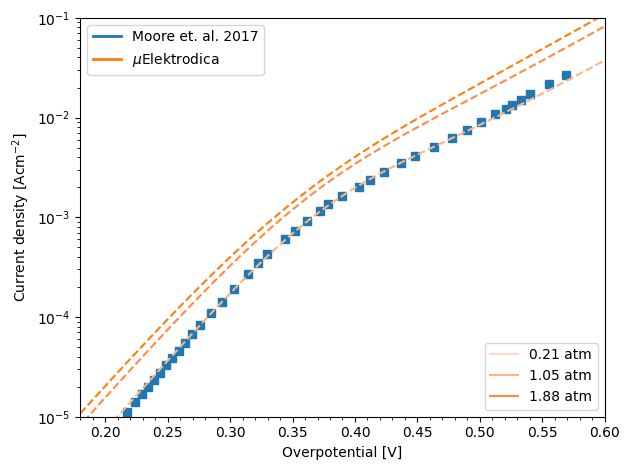

In [3]:
c0_oxygen = np.array([0.21, 1.05, 1.88])
pressure_legend = []
vj_data = pd.read_csv(directory + "/MooreData/current_p021.csv", comment='#').values
plt.plot(vj_data[:, 0], vj_data[:, 1], marker="s", linestyle="", color="tab:blue")
for i, c0 in enumerate(c0_oxygen):
    melek.data.species.c0_reactants = np.array([c0, 1])
    results=melek.strategy.solver()
    plt.plot(melek.potential, abs(results.j), linestyle="--",color=colors[i+1])
    pressure_legend.append(
        Line2D([0], [0], linestyle="-", color=colors[i], label=rf"{c0} atm")
    )
plt.ylabel(r"Current density [Acm$^{-2}$]")
plt.xlabel("Overpotential [V]")
plt.yscale("log")
plt.minorticks_on()
first_legend = plt.legend(handles=pressure_legend, loc="lower right")
plt.gca().add_artist(first_legend)
plt.legend(handles=solutions_legend, loc="upper left")
plt.ylim(1e-5, 1e-1)
plt.xlim(0.18, 0.6)
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight", format="png")
plt.show()

In [4]:
Kpy.operation.temperature = 50 + 273.15
Kpy.species.c0_reactants = np.array([0.21, 1])
F = Fitter(Kpy, vj_data[:,0], vj_data[:,1])
print(f'Fitter Results for p_O2 0.21 atm.\n'
      f'{writer.display_table('Reactions', F)}\n\n'
      f'{writer.display_table('Species', F)}\n')

Fitter Results for p_O2 0.21 atm.
+-------------+--------------------------+
| Reactions   |   Activation energy [eV] |
+=============+==========================+
| DA          |                 0.358875 |
+-------------+--------------------------+
| RA          |                 0.576553 |
+-------------+--------------------------+
| RT          |                 0.563671 |
+-------------+--------------------------+
| RD          |                 0.26685  |
+-------------+--------------------------+

+-----------+-------------------------+
| Species   |   Formation energy [eV] |
+===========+=========================+
| O*        |               -0.410691 |
+-----------+-------------------------+
| OH*       |               -0.36385  |
+-----------+-------------------------+



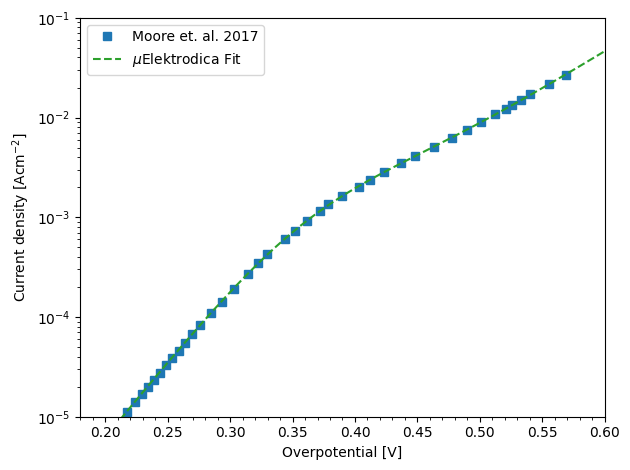

In [8]:
data.reactions.ga = F.ga_fit
data.species.g_formation_ads = F.gf_fit
Kpy = Kpynetic(data)
melek = Calculator(Kpy )
plt.plot(vj_data[:, 0], vj_data[:, 1], marker="s", linestyle="", color="tab:blue", label="Moore et. al. 2017")
plt.plot(melek.potential, abs(melek.results.j), linestyle="--",color="tab:green", label=r"$\mu$Elektrodica Fit")
plt.ylabel(r"Current density [Acm$^{-2}$]")
plt.xlabel("Overpotential [V]")
plt.yscale("log")
plt.legend(loc="upper left")
plt.ylim(1e-5, 1e-1)
plt.xlim(0.18, 0.6)
plt.minorticks_on()
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight", format="png")
plt.show()

Free energy diagram for O2 <--> H2O


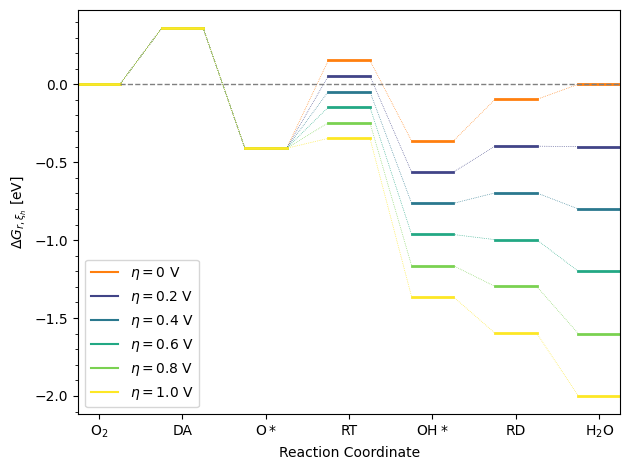

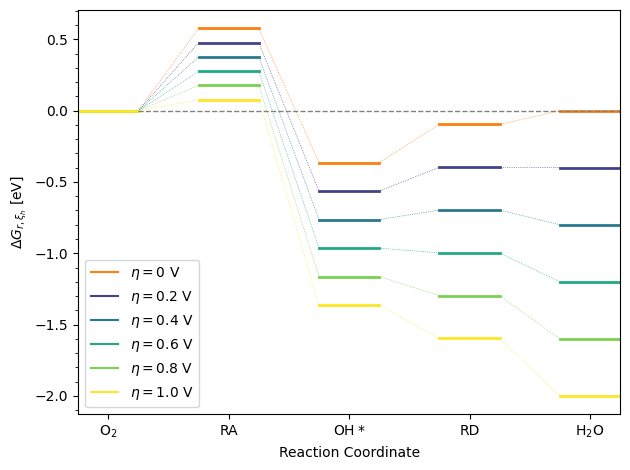

In [9]:
source, target = ['O2', 'H2O']
print(f'Free energy diagram for {source} <--> {target}')
overpotentials = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
fname = 'free_energy_diagram'
Coordinator(Kpy).plot_rxn_coords_potential(source, target, overpotentials, fname)

## References
1. Moore, M., Putz, A., and Secanell, M. (2013). Investigation of the ORR using the double-trap intrinsic kinetic model. Journal of the Electrochemical Society, 160(6), F670, http://dx.doi.org/10.1149/2.123306jes.